In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml, make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from importance_feature_selector import ImportanceFeatureSelector

# https://erdogant.github.io/distfit/pages/html/Parametric.html

In [2]:

X, y = make_classification(n_samples=10000)

X = pd.DataFrame(X, columns=[f'f_{i}' for i in range(X.shape[1])])

fs = ImportanceFeatureSelector(
    estimator=RandomForestClassifier(random_state=123),
    norm=True,
    rand=True, 
    exp=True, 
    choice=True, 
    binom=True,
    cv=3
)

X_selected = fs.fit_transform(X, y)



estimator = RandomForestClassifier(random_state=1234)
print("\nAll Features")
print(X.columns.to_list())


cv = cross_validate(estimator,X, y, scoring=['accuracy','recall','precision'], cv=3)
for k,v in cv.items():
    print(k, np.mean(v))


print("\nReduced Features")
print(X_selected.columns.to_list())
estimator = RandomForestClassifier(random_state=1234)
cv = cross_validate(estimator,X_selected, y, scoring=['accuracy','recall','precision'], cv=3)
for k,v in cv.items():
    print(k, np.mean(v))


All Features
['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19']
fit_time 1.5710344314575195
score_time 0.039734601974487305
test_accuracy 0.9936999398800109
test_recall 0.9934021588967578
test_precision 0.9940011271391942

Reduced Features
['f_7', 'f_8', 'f_14', 'f_19']
fit_time 0.8320788542429606
score_time 0.03911280632019043
test_accuracy 0.9935998698850089
test_recall 0.9930022388807611
test_precision 0.9941943794918296


In [2]:
# data = fetch_openml('adult', version=2, as_frame=True)
data = fetch_openml('credit-g', version=1, as_frame=True)


In [3]:
X = data['data']
y = data['target']
print(X.shape, y.shape)

(1000, 20) (1000,)


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   float64 
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   float64 
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   float64 
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   float64 
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [5]:
X.head(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes


In [7]:
y.head(3)

0    good
1     bad
2    good
Name: class, dtype: category
Categories (2, object): ['good', 'bad']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [36]:
num_features = X.select_dtypes(include='number').columns.to_list()
cat_features = X.select_dtypes(exclude='number').columns.to_list()

cardinalitites = [
    X[f].nunique()
    for f in cat_features
]

max_one_hot = 10
oh_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c<=max_one_hot]
ord_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c>max_one_hot]

In [37]:
col_transformer = ColumnTransformer([
    ('oh_cat_features', make_pipeline(
        SimpleImputer(strategy='most_frequent'), 
        OneHotEncoder(sparse=False, handle_unknown='ignore')
        ), 
        oh_cat_features
    ),
    ('ord_cat_features', make_pipeline(
        SimpleImputer(strategy='most_frequent'), 
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        ), 
        ord_cat_features
    ),
    ('num_features', make_pipeline(
        SimpleImputer(strategy='median'), 
        StandardScaler()
        ), 
        num_features
    ),
])

fu_base = FeatureUnion([
    (
        'fu_col', 
        col_transformer
    )
])

In [38]:
# Baseline
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

rf_base = make_pipeline(
    fu_base,
    RandomForestClassifier(
        n_estimators=150,
        max_depth=6,
        class_weight={i:sum(y_train==i)/y_train.shape[0] for i in np.unique(y_train)},
        random_state=123
        )
) 

cross_validate(
    rf_base, 
    X_train, 
    y_train, 
    scoring=['accuracy','recall','precision'], 
    cv=5, 
    return_train_score=True
)


{'fit_time': array([0.27432203, 0.23765922, 0.22628713, 0.22807503, 0.23040891]),
 'score_time': array([0.02934909, 0.02648878, 0.02607799, 0.02789402, 0.0258193 ]),
 'test_accuracy': array([0.70555556, 0.72222222, 0.71111111, 0.72222222, 0.70555556]),
 'train_accuracy': array([0.74166667, 0.74583333, 0.74444444, 0.75138889, 0.74166667]),
 'test_recall': array([0.9921875, 1.       , 1.       , 0.9921875, 0.9921875]),
 'train_recall': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.70949721, 0.71910112, 0.71111111, 0.72159091, 0.70949721]),
 'train_precision': array([0.73352436, 0.73669065, 0.73563218, 0.74095514, 0.73352436])}

In [39]:
rf_base.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('fu_col',
                                                 ColumnTransformer(transformers=[('oh_cat_features',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['checking_status',
                                                                                   'credit_history',
                                                                                   'purpose',
                                                                                   'savings_status',
                                                                                   'employment',
                                                                                   'per...
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                                  ['duration',
                                                                                   'credit_amount',
                                                                                   'installment_commitment',
                                                                                   'residence_since',
                                                                                   'age',
                                                                                   'existing_credits',
                                                                                   'num_dependents'])]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.28888888888888886,
                                                      1: 0.7111111111111111},
                                        max_depth=6, n_estimators=150,
                                        random_state=123))])

In [40]:
y_pred = rf_base.predict(X_test)
y_test = label_encoder.transform(y_test)
accuracy_score(y_test, y_pred)

0.63

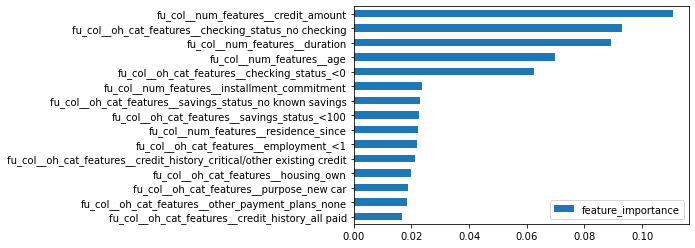

In [42]:
feature_importances = pd.DataFrame(
    rf_base.steps[-1][1].feature_importances_,
    index=rf_base[:-1].get_feature_names_out(),
    columns=['feature_importance']
).sort_values('feature_importance', ascending=False)
feature_importances.sort_values('feature_importance')[-15:].plot(kind='barh')
plt.show()

## Feature Selection

In [43]:
# Feature Selection
train_size = X_train.shape[0]

# Generate random features
x_norm = pd.DataFrame(np.random.normal(size=(train_size,1)), columns=['x_norm']) 
x_rand = pd.DataFrame(np.random.random(size=(train_size,1)), columns=['x_rand'])
x_exp = pd.DataFrame(np.random.exponential(size=(train_size,1)), columns=['x_exp'])
x_choice = pd.DataFrame(np.random.choice([i for i in range(10)], size=(train_size,1)), columns=['x_choice'])
x_binom = pd.DataFrame(np.random.binomial(n=1, p=0.7, size=(train_size,1))  , columns=['x_binom'])

X_random = pd.concat([
    x_norm,
    x_rand,
    x_exp,
    x_choice,
    x_binom
    ], axis=1)

random_features = X_random.columns.to_list()

In [89]:
# Optionally
# shuffled_features = X.columns.to_list()[:2]

# shuffled_num_features = X[shuffled_features].select_dtypes(include='number').columns.to_list()
# shuffled_cat_features = X[shuffled_features].select_dtypes(exclude='number').columns.to_list()

# shuffled_cardinalitites = [
#     X[f].nunique()
#     for f in cat_features
# ]
# shuffled_oh_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c<=max_one_hot]
# shuffled_ord_cat_features = [cat_features[i] for i,c in enumerate(cardinalitites) if c>max_one_hot]


In [44]:
X_train_noise = pd.concat([
    X_train.reset_index(drop=True),
    X_random.reset_index(drop=True)
], axis=1)

X_train_noise.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,existing_credits,job,num_dependents,own_telephone,foreign_worker,x_norm,x_rand,x_exp,x_choice,x_binom
0,0<=X<200,36.0,existing paid,radio/tv,4795.0,<100,<1,4.0,female div/dep/mar,none,...,1.0,high qualif/self emp/mgmt,1.0,yes,yes,0.263090,0.396670,0.435299,4,1
1,<0,12.0,critical/other existing credit,radio/tv,385.0,<100,4<=X<7,4.0,female div/dep/mar,none,...,4.0,unskilled resident,1.0,yes,yes,2.051853,0.557859,0.243153,5,0
2,>=200,15.0,existing paid,radio/tv,2327.0,<100,<1,2.0,female div/dep/mar,none,...,1.0,unskilled resident,1.0,none,yes,-0.556509,0.561378,1.693712,4,1
3,no checking,12.0,critical/other existing credit,new car,1163.0,500<=X<1000,1<=X<4,4.0,male single,none,...,1.0,skilled,1.0,yes,yes,0.658627,0.179517,0.131877,9,1
4,no checking,4.0,critical/other existing credit,new car,3380.0,<100,4<=X<7,1.0,female div/dep/mar,none,...,1.0,skilled,2.0,none,yes,-0.376920,0.112193,0.836641,9,1


In [45]:
random_col_transformer = ColumnTransformer([
    ('random_features', 'passthrough', random_features)  
])

fu_noise = FeatureUnion([
    (
        'fu_col', 
        col_transformer
    ),
    (
        'fu_random_col',
        random_col_transformer
    ),
])

In [46]:
rf_noise = make_pipeline(
    fu_noise,
    RandomForestClassifier(
        n_estimators=150,
        max_depth=6,
        class_weight={i:sum(y_train==i)/y_train.shape[0] for i in np.unique(y_train)},
        random_state=123
        )
) 

cross_validate(
    rf_base, 
    X_train_noise, 
    y_train, 
    scoring=['accuracy','recall','precision'], 
    cv=5, 
    return_train_score=True
)


{'fit_time': array([0.31866789, 0.28730202, 0.24490428, 0.30749798, 0.25420594]),
 'score_time': array([0.02367282, 0.02412796, 0.03005075, 0.02652788, 0.03188562]),
 'test_accuracy': array([0.70555556, 0.72222222, 0.71111111, 0.72222222, 0.70555556]),
 'train_accuracy': array([0.74166667, 0.74583333, 0.74444444, 0.75138889, 0.74166667]),
 'test_recall': array([0.9921875, 1.       , 1.       , 0.9921875, 0.9921875]),
 'train_recall': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.70949721, 0.71910112, 0.71111111, 0.72159091, 0.70949721]),
 'train_precision': array([0.73352436, 0.73669065, 0.73563218, 0.74095514, 0.73352436])}

In [48]:
from sklearn.model_selection import KFold
from sklearn.base import clone


def compute_cv_feature_importances(pipeline, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits)

    feature_importances = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipeline_ = clone(pipeline)

        pipeline_.fit(X_train, y_train)

        feature_importances.append(
            pipeline_.steps[-1][1].feature_importances_
        )
      
    return  feature_importances
        
feature_importances = compute_cv_feature_importances(rf_noise, X_train_noise, y_train)

In [49]:
# test_size = X_test.shape[0]

# x_norm = pd.DataFrame(np.random.normal(size=(test_size,1)), columns=['x_norm']) 
# x_binom = pd.DataFrame(np.random.binomial(n=1, p=0.7, size=(test_size,1))  , columns=['x_binom'])
# X_random_test = pd.concat(
#     [x_norm,x_binom],
#      axis=1
# )

# X_test_noise= pd.concat([
#     X_test.reset_index(drop=True),
#     X_random_test.reset_index(drop=True)
# ], axis=1)

rf_noise.fit(X_train_noise, y_train)

# y_pred = rf_noise.predict(X_test_noise)
# accuracy_score(y_test, y_pred)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('fu_col',
                                                 ColumnTransformer(transformers=[('oh_cat_features',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['checking_status',
                                                                                   'credit_history',
                                                                                   'purpose',
                                                                                   'savings_status',
                                                                                   'employment',
                                                                                   'per...
                                                                                   'residence_since',
                                                                                   'age',
                                                                                   'existing_credits',
                                                                                   'num_dependents'])])),
                                                ('fu_random_col',
                                                 ColumnTransformer(transformers=[('random_features',
                                                                                  'passthrough',
                                                                                  ['x_norm',
                                                                                   'x_rand',
                                                                                   'x_exp',
                                                                                   'x_choice',
                                                                                   'x_binom'])]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.28888888888888886,
                                                      1: 0.7111111111111111},
                                        max_depth=6, n_estimators=150,
                                        random_state=123))])

<AxesSubplot:>

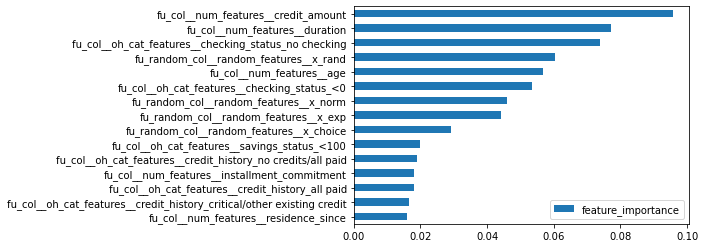

In [50]:
# feature_importances_noise = pd.DataFrame(
#     rf_noise.steps[-1][1].feature_importances_,
#     index=rf_noise[:-1].get_feature_names_out(),
#     columns=['feature_importance']
# ).sort_values('feature_importance', ascending=False)
# feature_importances_noise.sort_values('feature_importance')[-15:].plot(kind='barh')

feature_importances_noise = pd.DataFrame(
    np.mean(feature_importances, axis=0),
    index=rf_noise[:-1].get_feature_names_out(),
    columns=['feature_importance']
).sort_values('feature_importance', ascending=False)
feature_importances_noise.sort_values('feature_importance')[-15:].plot(kind='barh')


In [51]:
feature_names = list(rf_noise[:-1].get_feature_names_out())

In [52]:
random_feature_names = [f for f in feature_names if 'random' in f]
random_feature_idx = [feature_names.index(f) for f in feature_names if 'random' in f]


In [53]:
threshold = feature_importances_noise.loc[random_feature_names,:].values.max()
selected_feature_importances = feature_importances_noise[feature_importances_noise['feature_importance']>threshold]

In [54]:
selected_feature_importances

,feature_importance
fu_col__num_features__credit_amount,0.095681
fu_col__num_features__duration,0.077178
fu_col__oh_cat_features__checking_status_no checking,0.073732


In [56]:
# X_train_noise
selected_features = selected_feature_importances.index.to_list()
selected_feature_idx = [feature_names.index(f) for f in selected_features]

selected_col_transformer = ColumnTransformer([
    ('selected_features', 'passthrough', selected_feature_idx)  
])    

rf_selected = make_pipeline(
    fu_noise,
    selected_col_transformer,
    RandomForestClassifier()
) 
cross_validate(rf_selected, X_train_noise, y_train, scoring=['accuracy','recall','precision'], cv=5, return_train_score=True)


{'fit_time': array([0.22279668, 0.18432784, 0.16069198, 0.15918207, 0.16181183]),
 'score_time': array([0.02242708, 0.02266407, 0.02037692, 0.021312  , 0.02205181]),
 'test_accuracy': array([0.63888889, 0.67777778, 0.7       , 0.66111111, 0.73333333]),
 'train_accuracy': array([1.        , 0.99861111, 0.99861111, 1.        , 0.99861111]),
 'test_recall': array([0.7890625, 0.8203125, 0.796875 , 0.7421875, 0.84375  ]),
 'train_recall': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.72661871, 0.75      , 0.78461538, 0.77235772, 0.79411765]),
 'train_precision': array([1.        , 0.99805068, 0.99805068, 1.        , 0.99805068])}

In [201]:

class AutoEncoder(BaseEstimator, TransformerMixin):

    def __init__(
        self, 

        numeric_features = None,
        impute_numeric = True, 
        numeric_imputer = None,
        scale_numeric = False,
        numeric_scaler = None,

        categorical_features = None,
        max_one_hot = 10, 
        impute_categorical = True,
        categorical_imputer = None,

        encode_target = True,
        ):

        self.numeric_features = numeric_features
        self.impute_numeric = impute_numeric

        if self.impute_numeric:
            self.numeric_imputer = (
                numeric_imputer 
                if numeric_imputer 
                else SimpleImputer(strategy='median')
                )
        else:
            self.numeric_imputer = numeric_imputer

        self.scale_numeric = scale_numeric
        
        if self.scale_numeric:
            self.numeric_scaler = (
                numeric_scaler 
                if numeric_scaler 
                else StandardScaler()
                ) 
        else:
            self.numeric_scaler = numeric_scaler

        self.categorical_features = categorical_features
        self.max_one_hot = max_one_hot
        self.impute_categorical = impute_categorical
        
        if self.impute_categorical:
            self.categorical_imputer = (
                categorical_imputer 
                if categorical_imputer 
                else SimpleImputer(strategy='most_frequent')
                ) 
        else:
            self.categorical_imputer = categorical_imputer

        
        self.encode_target = encode_target


    def fit(self, X, y):

        # validate inputs. Must be dataframes
        if not isinstance(X, pd.DataFrame):
            raise Exception("X must be a pandas DataFrame object")

        if not isinstance(y, (pd.Series, pd.DataFrame)):
            raise Exception("y must be a pandas DataFrame or Series object")

        if not self.numeric_features:
            self.numeric_features = X.select_dtypes(include='number').columns.to_list()

        if not self.categorical_features:
            self.categorical_features = X.select_dtypes(exclude='number').columns.to_list()

        self.cardinalitites_ = [
            X[f].nunique()
            for f in self.categorical_features
        ]

        self.oh_categorical_features_ = [
            self.categorical_features[i] for i,c in enumerate(self.cardinalitites_) 
            if c <= self.max_one_hot
            ]

        self.ord_categorical_features_ = [
            self.categorical_features[i] for i,c in enumerate(self.cardinalitites_) 
            if c > self.max_one_hot
            ]
        
        
        if self.impute_categorical:
            oh_cat_pipeline = make_pipeline(
                self.categorical_imputer, 
                OneHotEncoder(sparse=False, handle_unknown='ignore')
            )
            ord_cat_pipeline = make_pipeline(
                self.categorical_imputer, 
                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            )
        else:
            oh_cat_pipeline = make_pipeline(
                OneHotEncoder(sparse=False, handle_unknown='ignore')
            ) 
            ord_cat_pipeline = make_pipeline(
                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            ) 

        if self.impute_numeric and self.scale_numeric:
            num_pipeline =  make_pipeline(
                SimpleImputer(strategy='median'), 
                StandardScaler()
            )
        elif self.impute_numeric and not self.scale_numeric:
             num_pipeline =  make_pipeline(
                SimpleImputer(strategy='median'), 
            )           
        elif not self.impute_numeric and self.scale_numeric:
            num_pipeline =  make_pipeline(
                StandardScaler()
            )
        else:
            num_pipeline="passthrough"
                

        self.pipeline = ColumnTransformer([
            ('oh_cat_features',
                oh_cat_pipeline,
                oh_cat_features
            ),
            ('ord_cat_features',
                ord_cat_pipeline, 
                ord_cat_features
            ),
            ('num_features',
                num_pipeline, 
                num_features
            ),
        ])

        if self.encode_target:
            self.label_encoder_ = LabelEncoder()
            y = self.label_encoder_.fit_transform(y)

        self.pipeline.fit(X, y)

        return self

    def transform(self, X):
        X_out = self.pipeline.transform(X)

        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(
                X_out,
                columns = self.get_feature_names_out()
            )
        else:
            return X_out

    def get_feature_names_out(self):
        return self.pipeline.get_feature_names_out()





In [202]:
ae = AutoEncoder()
ae.fit(X,y)
ae.transform(X)

,oh_cat_features__checking_status_0<=X<200,oh_cat_features__checking_status_<0,oh_cat_features__checking_status_>=200,oh_cat_features__checking_status_no checking,oh_cat_features__credit_history_all paid,oh_cat_features__credit_history_critical/other existing credit,oh_cat_features__credit_history_delayed previously,oh_cat_features__credit_history_existing paid,oh_cat_features__credit_history_no credits/all paid,oh_cat_features__purpose_business,...,oh_cat_features__own_telephone_yes,oh_cat_features__foreign_worker_no,oh_cat_features__foreign_worker_yes,num_features__duration,num_features__credit_amount,num_features__installment_commitment,num_features__residence_since,num_features__age,num_features__existing_credits,num_features__num_dependents
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,48.0,5951.0,2.0,2.0,22.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,12.0,2096.0,2.0,3.0,49.0,1.0,2.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,42.0,7882.0,2.0,4.0,45.0,1.0,2.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,24.0,4870.0,3.0,4.0,53.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,12.0,1736.0,3.0,4.0,31.0,1.0,1.0
996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,30.0,3857.0,4.0,4.0,40.0,1.0,1.0
997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,12.0,804.0,4.0,4.0,38.0,1.0,1.0
998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,45.0,1845.0,4.0,4.0,23.0,1.0,1.0


In [203]:
pipe = Pipeline([
    ('auto_encoder', AutoEncoder()),
    ('model', RandomForestClassifier())
])

In [204]:
pipe.fit(X,y)

Pipeline(steps=[('auto_encoder',
                 AutoEncoder(categorical_features=['checking_status',
                                                   'credit_history', 'purpose',
                                                   'savings_status',
                                                   'employment',
                                                   'personal_status',
                                                   'other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans',
                                                   'housing', 'job',
                                                   'own_telephone',
                                                   'foreign_worker'],
                             categorical_imputer=SimpleImputer(strategy='most_frequent'),
                             numeric_features=['duration', 'credit_amount',
                                               'installment_commitment',
                                               'residence_since', 'age',
                                               'existing_credits',
                                               'num_dependents'],
                             numeric_imputer=SimpleImputer(strategy='median'))),
                ('model', RandomForestClassifier())])

In [205]:
pipe.predict(X)

array(['good', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'bad', 'bad', 'bad', 'good', 'bad', 'good', 'bad', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad',
       'good', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'bad', 'good', 'bad', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good',
       'bad', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'bad', 'good', 'go

In [207]:
class ImportanceFeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, estimator, norm=True, rand=True, exp=True, choice=True, binom=True, cv=True):
        self.estimator = estimator
        self.norm = norm
        self.rand = rand
        self.exp = exp
        self.choice = choice
        self.binom = binom
        self.cv = cv

        if not any([norm,rand,exp,choice,binom]):
            raise Exception("At least one of random features must be True")

    
    def generate_random_features(self, X):

        size=X.shape[0]
        index=X.index
        random_features = []

        if self.norm:
            x_norm = pd.DataFrame(np.random.normal(size=(size,1)), columns=['NOISE_x_norm'], index=index) 
            random_features.append(x_norm)
        if self.rand:
            x_rand = pd.DataFrame(np.random.random(size=(size,1)), columns=['NOISE_x_rand'], index=index)
            random_features.append(x_rand)
        if self.exp:
            x_exp = pd.DataFrame(np.random.exponential(size=(size,1)), columns=['NOISE_x_exp'], index=index)
            random_features.append(x_exp)
        if self.choice:
            x_choice = pd.DataFrame(np.random.choice([i for i in range(10)], size=(size,1)), columns=['NOISE_x_choice'], index=index)
            random_features.append(x_choice)
        if self.binom:
            x_binom = pd.DataFrame(np.random.binomial(n=1, p=0.7, size=(size,1)), columns=['NOISE_x_binom'], index=index)
            random_features.append(x_binom)

        X_random = pd.concat(random_features, axis=1)

        return X_random


    def compute_cv_feature_importances(self, estimator, X, y, n_splits=5):
        
        kf = KFold(n_splits=n_splits)

        feature_importances = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            estimator_ = clone(estimator)

            estimator_.fit(X_train, y_train)

            feature_importances.append(
                estimator_.feature_importances_
            )
        
        return np.mean(feature_importances, axis=0)


    def fit(self, X, y):

        if not isinstance(X, pd.DataFrame):
            raise Exception("X must be a pandas DataFrame object")

        X_random = self.generate_random_features(X)

        X_noise = pd.concat([X, X_random], axis=1)
        
        if self.cv:
            feature_importances = self.compute_cv_feature_importances(self.estimator, X_noise, y)
            self.estimator.fit(X_noise, y)
        else:
            self.estimator.fit(X_noise, y)
            feature_importances = self.estimator.feature_importances_

        feature_names = X_noise.columns.to_list()

        self.feature_importances_ = pd.DataFrame(
            feature_importances,
            index=feature_names,
            columns=['feature_importance']
        ).sort_values('feature_importance', ascending=False)

        random_feature_names = [f for f in feature_names if 'NOISE' in f]
        random_feature_idx = [feature_names.index(f) for f in feature_names if 'NOISE' in f]

        threshold = self.feature_importances_.loc[random_feature_names,:].values.max()

        selected_features_importance_ = self.feature_importances_[
            self.feature_importances_['feature_importance']>threshold
            ]

        self.selected_features_names = selected_features_importance_.index.to_list()
        
        self.selected_features_idx = [feature_names.index(f) for f in feature_names if f in self.selected_features_names]

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.iloc[:,self.selected_features_idx]
        else:
            return X[self.selected_features_idx]
         


All Features
fit_time 0.1346672534942627
score_time 0.014072179794311523
test_accuracy 0.8700000000000001
test_recall 0.8577777777777778
test_precision 0.9051282051282051

Reduced Features
fit_time 0.12737679481506348
score_time 0.012733173370361329
test_accuracy 0.9099999999999999
test_recall 0.9199999999999999
test_precision 0.9133333333333333


In [183]:

ae = AutoEncoder()

X_encoded = pd.DataFrame(
    ae.fit_transform(X,y),
    columns = ae.get_feature_names_out()
)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


fs = ImportanceFeatureSelector(
    estimator=RandomForestClassifier(max_depth=4, random_state=123),
    norm=True,
    rand=False, 
    exp=False, 
    choice=True, 
    binom=False
)

fs.fit(X_encoded, y_encoded)

ImportanceFeatureSelector(binom=False,
                          estimator=RandomForestClassifier(max_depth=4,
                                                           random_state=123),
                          exp=False, rand=False)

In [184]:
fs.transform(X_encoded)

[1, 3, 54, 55]


,oh_cat_features__checking_status_<0,oh_cat_features__checking_status_no checking,num_features__duration,num_features__credit_amount
0,1.0,0.0,6.0,1169.0
1,0.0,0.0,48.0,5951.0
2,0.0,1.0,12.0,2096.0
3,1.0,0.0,42.0,7882.0
4,1.0,0.0,24.0,4870.0
...,...,...,...,...
995,0.0,1.0,12.0,1736.0
996,1.0,0.0,30.0,3857.0
997,0.0,1.0,12.0,804.0
998,1.0,0.0,45.0,1845.0


In [198]:
pipe = Pipeline([
    ('auto_encoder', AutoEncoder()),
    ('selector',ImportanceFeatureSelector(
            estimator=RandomForestClassifier(max_depth=4, random_state=123),
            norm=True,
            rand=False, 
            exp=False, 
            choice=True, 
            binom=True
        )
    ),
    ('model', RandomForestClassifier())
])

In [199]:
pipe.fit(X,y)

[1, 3, 5, 54, 55, 58]


Pipeline(steps=[('auto_encoder',
                 AutoEncoder(categorical_features=['checking_status',
                                                   'credit_history', 'purpose',
                                                   'savings_status',
                                                   'employment',
                                                   'personal_status',
                                                   'other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans',
                                                   'housing', 'job',
                                                   'own_telephone',
                                                   'foreign_worker'],
                             categorical_imputer=SimpleImputer(strategy='most_frequent'),
                             numeric_features=['duration', 'credit_amount',
                                               'installment_commitment',
                                               'residence_since', 'age',
                                               'existing_credits',
                                               'num_dependents'],
                             numeric_imputer=SimpleImputer(strategy='median'))),
                ('selector',
                 ImportanceFeatureSelector(estimator=RandomForestClassifier(max_depth=4,
                                                                            random_state=123),
                                           exp=False, rand=False)),
                ('model', RandomForestClassifier())])

In [200]:
pipe.predict(X)

[1, 3, 5, 54, 55, 58]


array(['good', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'bad', 'bad', 'bad', 'good', 'bad', 'good', 'bad', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good',
       'good', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad',
       'good', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'bad', 'good', 'bad', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good',
       'bad', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'bad', 'good', 'go